In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
class CFG:
    SEED = 42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED)  # seed 고정

In [4]:
train = pd.read_csv('open/train.csv')
test = pd.read_csv('open/test.csv')

# 필요 없는 컬럼 삭제 및 데이터 분리

def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class','father','mother','gender'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id','father','mother','gender'])
        return df_x

train_x, train_y = get_x_y(train)
test_x = get_x_y(test)
train_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,2,G G,A G,A A,G A,C A,A A,A A,G G,A A,G G,A G,A A,A A,A A,A A
1,2,A G,A G,C A,A A,A A,A G,A A,G A,A A,A G,A A,G A,G G,A A,A A
2,2,G G,G G,A A,G A,C C,G G,A A,G A,G A,A G,A A,A A,A A,A A,A A
3,1,A A,G G,A A,G A,A A,G G,G G,A A,G G,A G,G G,G G,G G,A A,G G
4,2,G G,G G,C C,A A,C C,A A,A A,A A,A A,G G,A A,A A,A G,A A,G A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,A G,A G,A A,G A,C C,A G,A A,G A,A A,G G,A G,G A,A A,A A,A A
258,2,G G,A A,C A,A A,A A,A G,G A,G A,A A,A G,A G,A A,A G,A A,G A
259,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A A,G G,G G,G G,C A,G G
260,1,A A,G G,A A,G A,A A,G G,G G,A A,G A,A G,A G,G A,G G,C A,G G


In [5]:
# 분석을 위해 snp_ 데이터를 labelencoder() 이용하여 문자-> 숫자로 변경. 

class_le = preprocessing.LabelEncoder()  
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

LabelEncoder()

In [6]:
for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])

In [7]:
# 20퍼센트는 테스트 셋으로 남겨두기. 

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)

In [8]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(209, 16) (53, 16) (209,) (53,)


In [9]:
# 신경망 생성. Dense 5개. 활성화 함수는 입력층은 ReLU,나머지는 softmax 사용. 
# 컬럼의 수가 16개 (trait, SNP_01~15) 이므로 input_shape은 (16,)이 된다. 
# 출력층 값은 ABC 3개중에 하나가 나와야 하므로 unit=3로 지정. 

model = keras.Sequential()
model.add(keras.layers.Dense(units=100, activation='ReLU', input_shape=(16,)))
model.add(keras.layers.Dense(units=100, activation='softmax'))
model.add(keras.layers.Dense(units=100, activation='softmax'))
model.add(keras.layers.Dense(units=100, activation='softmax'))

model.add(keras.layers.Dense(units=3, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1700      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 32,303
Trainable params: 32,303
Non-trainable params: 0
_________________________________________________________________


In [11]:
# compile 작업. 최적화 알고리즘 adam사용. 다중분류 손실함수. 정확도 사용. 

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [12]:
# 600번 학습. (횟수는 줄일 수 있을 것 같다.)

checkpoint_cb =  keras.callbacks.ModelCheckpoint('SGDclassifer_den5.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=600)

Epoch 1/600
7/7 [==============================] - 0s 3ms/step - loss: 1.0962 - accuracy: 0.4354
Epoch 2/600
7/7 [==============================] - 0s 3ms/step - loss: 1.0939 - accuracy: 0.4354
Epoch 3/600
7/7 [==============================] - 0s 3ms/step - loss: 1.0919 - accuracy: 0.4354
Epoch 4/600
7/7 [==============================] - 0s 0s/step - loss: 1.0906 - accuracy: 0.4354
Epoch 5/600
7/7 [==============================] - 0s 0s/step - loss: 1.0890 - accuracy: 0.4354
Epoch 6/600
7/7 [==============================] - 0s 0s/step - loss: 1.0877 - accuracy: 0.4354
Epoch 7/600
7/7 [==============================] - 0s 0s/step - loss: 1.0865 - accuracy: 0.4354
Epoch 8/600
7/7 [==============================] - 0s 2ms/step - loss: 1.0852 - accuracy: 0.4354
Epoch 9/600
7/7 [==============================] - 0s 1ms/step - loss: 1.0844 - accuracy: 0.4354
Epoch 10/600
7/7 [==============================] - 0s 3ms/step - loss: 1.0833 - accuracy: 0.4354
Epoch 11/600
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.9728 - accuracy: 0.4354
Epoch 85/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9665 - accuracy: 0.4354
Epoch 86/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9601 - accuracy: 0.4354
Epoch 87/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9534 - accuracy: 0.4354
Epoch 88/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9464 - accuracy: 0.4354
Epoch 89/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9394 - accuracy: 0.4354
Epoch 90/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9323 - accuracy: 0.4354
Epoch 91/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9256 - accuracy: 0.4354
Epoch 92/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9166 - accuracy: 0.4354
Epoch 93/600
7/7 [==============================] - 0s 3ms/step - loss: 0.9091 - accuracy: 0.4354
Epoch 94/600
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.2482 - accuracy: 0.9952
Epoch 168/600
7/7 [==============================] - 0s 2ms/step - loss: 0.2436 - accuracy: 0.9952
Epoch 169/600
7/7 [==============================] - 0s 2ms/step - loss: 0.2391 - accuracy: 0.9952
Epoch 170/600
7/7 [==============================] - 0s 842us/step - loss: 0.2348 - accuracy: 0.9952
Epoch 171/600
7/7 [==============================] - 0s 3ms/step - loss: 0.2305 - accuracy: 0.9952
Epoch 172/600
7/7 [==============================] - 0s 4ms/step - loss: 0.2264 - accuracy: 0.9952
Epoch 173/600
7/7 [==============================] - 0s 2ms/step - loss: 0.2224 - accuracy: 0.9952
Epoch 174/600
7/7 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.9952
Epoch 175/600
7/7 [==============================] - 0s 3ms/step - loss: 0.2146 - accuracy: 0.9952
Epoch 176/600
7/7 [==============================] - 0s 3ms/step - loss: 0.2109 - accuracy: 0.9952
Epoch 177/600
7/7 [===

7/7 [==============================] - 0s 3ms/step - loss: 0.0830 - accuracy: 0.9952
Epoch 251/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.9952
Epoch 252/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0817 - accuracy: 0.9952
Epoch 253/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0810 - accuracy: 0.9952
Epoch 254/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9952
Epoch 255/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0797 - accuracy: 0.9952
Epoch 256/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9952
Epoch 257/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0784 - accuracy: 0.9952
Epoch 258/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0778 - accuracy: 0.9952
Epoch 259/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0772 - accuracy: 0.9952
Epoch 260/600
7/7 [=====

7/7 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9952
Epoch 333/600
7/7 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.9952
Epoch 334/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0508 - accuracy: 0.9952
Epoch 335/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0506 - accuracy: 0.9952
Epoch 336/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9952
Epoch 337/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.9952
Epoch 338/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9952
Epoch 339/600
7/7 [==============================] - 0s 928us/step - loss: 0.0498 - accuracy: 0.9952
Epoch 340/600
7/7 [==============================] - 0s 0s/step - loss: 0.0496 - accuracy: 0.9952
Epoch 341/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9952
Epoch 342/600
7/7 [====

7/7 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9952
Epoch 415/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9952
Epoch 416/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9952
Epoch 417/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.9952
Epoch 418/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.9952
Epoch 419/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9952
Epoch 420/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9952
Epoch 421/600
7/7 [==============================] - 0s 4ms/step - loss: 0.0391 - accuracy: 0.9952
Epoch 422/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9952
Epoch 423/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.9952
Epoch 424/600
7/7 [=====

7/7 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.9952
Epoch 497/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.9952
Epoch 498/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 0.9952
Epoch 499/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 0.9952
Epoch 500/600
7/7 [==============================] - 0s 331us/step - loss: 0.0340 - accuracy: 0.9952
Epoch 501/600
7/7 [==============================] - 0s 0s/step - loss: 0.0340 - accuracy: 0.9952
Epoch 502/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9952
Epoch 503/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0339 - accuracy: 0.9952
Epoch 504/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0338 - accuracy: 0.9952
Epoch 505/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0338 - accuracy: 0.9952
Epoch 506/600
7/7 [====

7/7 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 0.9952
Epoch 579/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0312 - accuracy: 0.9952
Epoch 580/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9952
Epoch 581/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9952
Epoch 582/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9952
Epoch 583/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9952
Epoch 584/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9952
Epoch 585/600
7/7 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9952
Epoch 586/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9952
Epoch 587/600
7/7 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9952
Epoch 588/600
7/7 [=====

In [13]:
# 테스트 데이터 돌려보기. 

model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.5015 - accuracy: 0.9057


[0.5014582872390747, 0.9056603908538818]

In [14]:
preds = model.predict(test_x)

6/6 [==============================] - 0s 2ms/step


In [15]:
print(preds)

[[0.99437326 0.0026788  0.00294794]
 [0.002558   0.9868762  0.01056587]
 [0.00237821 0.00297418 0.99464744]
 [0.00237861 0.00297464 0.9946467 ]
 [0.99437326 0.0026788  0.00294795]
 [0.00255799 0.9868762  0.01056585]
 [0.00237881 0.00297487 0.99464625]
 [0.0025587  0.98687315 0.01056808]
 [0.99437326 0.0026788  0.00294795]
 [0.99437326 0.0026788  0.00294795]
 [0.00237821 0.00297418 0.99464744]
 [0.00255799 0.9868762  0.01056586]
 [0.00255799 0.9868762  0.01056586]
 [0.99437326 0.0026788  0.00294795]
 [0.00255813 0.9868755  0.0105663 ]
 [0.00255799 0.9868762  0.01056586]
 [0.99437326 0.0026788  0.00294795]
 [0.00255799 0.9868762  0.01056585]
 [0.00255799 0.9868762  0.01056585]
 [0.00237842 0.00297442 0.99464697]
 [0.00255799 0.9868762  0.01056586]
 [0.00255799 0.9868762  0.01056586]
 [0.00255801 0.9868762  0.01056591]
 [0.99437326 0.0026788  0.00294795]
 [0.00255799 0.9868762  0.01056586]
 [0.00255947 0.98687005 0.01057048]
 [0.00255802 0.98687595 0.01056593]
 [0.99437326 0.0026788  0.00

In [16]:
# 확률적 경사 하강법 분류를 사용. 

clf = SGDClassifier(random_state=CFG.SEED)
clf.fit(train_x, train_y)

SGDClassifier(random_state=42)

In [17]:
# # 예측 및 테스트 값 출력

preds = clf.predict(test_x)
print('Done.')
print(preds)
preds.shape
preds.ndim

Done.
[0 1 2 1 0 1 2 1 0 0 2 1 1 0 1 1 0 1 1 2 1 1 1 0 1 1 1 0 0 1 0 0 1 2 0 1 2
 1 1 2 0 1 2 1 1 1 1 2 1 2 0 1 0 1 1 1 2 0 1 2 0 1 2 2 2 0 1 0 0 1 1 1 0 0
 2 1 2 1 1 1 2 1 0 1 1 1 1 1 2 0 1 1 1 1 1 2 0 1 0 2 0 1 1 2 0 0 2 1 0 1 2
 1 1 1 1 0 0 2 1 2 0 1 1 2 2 1 1 1 0 1 0 0 1 1 1 2 0 0 1 0 0 0 2 1 1 1 0 1
 2 0 0 1 0 1 1 0 0 1 2 0 1 2 2 1 0 0 2 1 1 0 1 2 2 1 1]


1

In [18]:
# 저장

submit = pd.read_csv('sample_submission.csv')

submit['class'] = class_le.inverse_transform(preds)

submit.to_csv('open/answer/submitReLU.csv', index=False)

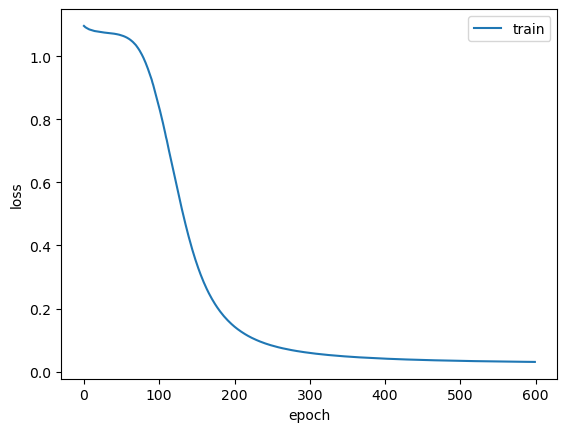

In [19]:
# loss 값 시각화.

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'])
plt.show()